In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
import ast
from tqdm import tqdm
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
df = pd.read_csv('../Dados/coordenadas_com_ocorrencias_especie.csv', index_col=0)
df['especie_abelha'] = df['especie_abelha'].apply(ast.literal_eval)

df

In [4]:
positivos = df[df['ocorrencia'] == True]
negativos = df[df['ocorrencia'] == False]

negativos_sampled = negativos.sample(n=len(positivos)*3, random_state=42)
df_balanceado = pd.concat([positivos, negativos_sampled]).sample(frac=1, random_state=42)

df_balanceado

,Latitude,Longitude,Sentinel-NDVI,Sentinel-NDWI,Precipitação,TempMax,TempMin,TempMedia,especie_abelha,ocorrencia
11265165,-5.07,-43.95,0.114577,-0.122740,30.881950,32.778698,21.893415,27.336056,[],False
11342437,-4.87,-55.23,0.032247,0.010616,37.635365,31.286911,21.672113,26.479511,[],False
11077430,-5.55,-39.70,0.101479,-0.132665,24.558130,30.786911,21.254065,26.020489,[],False
4267035,-22.92,-53.25,-0.069740,0.071051,32.274635,28.811464,15.885203,22.348333,[],False
8494278,-12.14,-38.42,0.018017,-0.019240,40.700160,28.852440,19.622927,24.237682,"[Melipona scutellaris, Scaptotrigona xanthotri...",True
...,...,...,...,...,...,...,...,...,...,...
12510934,-1.89,-51.86,0.027196,0.015368,33.331707,31.877073,22.040976,26.959024,[],False
8161042,-12.99,-38.78,0.068617,-0.050068,34.220570,28.581951,21.721300,25.151627,[Trigona spinipes],True
3734394,-24.28,-48.46,-0.024443,0.035447,38.357560,23.057398,13.221301,18.139349,[Scaptotrigona bipunctata],True
10871061,-6.07,-64.99,-0.110395,0.106982,36.478863,32.090164,22.106585,27.098373,[],False


In [8]:
features = ['Sentinel-NDVI', 'Sentinel-NDWI',
            'Precipitação', 'TempMedia', 'Latitude', 'Longitude']
# 'TempMax', 'TempMin', 
mlb = MultiLabelBinarizer()
y_all = mlb.fit_transform(df['especie_abelha'])
especies = mlb.classes_

X = df[features]
y = df["ocorrencia"]
df_full = df.copy()
df_full['target'] = y 

positivos = df[df['ocorrencia'] == True]
negativos = df[df['ocorrencia'] == False]

negativos_sampled = negativos.sample(n=len(positivos)*3, random_state=42)

df_balanceado = pd.concat([positivos, negativos_sampled]).sample(frac=1, random_state=42)

X_bal = df_balanceado[features]
y_bal = df_balanceado['ocorrencia']

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
coords = df[['Latitude', 'Longitude']].values

# Aplica PCA
pca = PCA(n_components=1)  # ou 2 se quiser manter duas componentes
coord_pca = pca.fit_transform(coords)

# Adiciona ao dataframe
df['Coord_PCA1'] = coord_pca[:, 0]  # primeira componente

## Regressão Logística

### Regressão com as variáveis

In [9]:
X.columns

Index(['Sentinel-NDVI', 'Sentinel-NDWI', 'Precipitação', 'TempMedia',
       'Latitude', 'Longitude'],
      dtype='object')

In [10]:
model = LogisticRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[6649  477]
 [1341 1041]]
              precision    recall  f1-score   support

       False       0.83      0.93      0.88      7126
        True       0.69      0.44      0.53      2382

    accuracy                           0.81      9508
   macro avg       0.76      0.69      0.71      9508
weighted avg       0.80      0.81      0.79      9508



In [13]:
X = df_balanceado[features]
X = sm.add_constant(X)  # adiciona o intercepto
y = df_balanceado['ocorrencia']
model = sm.Logit(y, X).fit()

print(model.summary())


Optimization terminated successfully.
         Current function value: 0.449166
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             ocorrencia   No. Observations:                31692
Model:                          Logit   Df Residuals:                    31685
Method:                           MLE   Df Model:                            6
Date:                Sun, 22 Jun 2025   Pseudo R-squ.:                  0.2012
Time:                        17:27:00   Log-Likelihood:                -14235.
converged:                       True   LL-Null:                       -17822.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.9434      0.217     22.822      0.000       4.519       5.368
Sentinel-NDVI   -12.

### Regressão com PCA

In [157]:
X = df_balanceado[features]
y = df_balanceado["ocorrencia"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_T_balanceado = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])

df_T_balanceado['Ocorrencia'] = y.values

df_T_balanceado

,PCA1,PCA2,Ocorrencia
0,-0.960245,0.853957,False
1,0.006981,1.233852,False
2,-0.823849,0.757945,False
3,1.843784,-0.091860,False
4,1.092152,0.314342,True
...,...,...,...
31687,-0.141151,1.649356,False
31688,0.393352,0.243737,True
31689,2.331693,-1.246132,True
31690,0.829614,2.044387,False


In [158]:
X_bal = df_T_balanceado[['PCA1', 'PCA2']]
y_bal = df_T_balanceado['Ocorrencia']

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [159]:
model = LogisticRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[6752  374]
 [1608  774]]
              precision    recall  f1-score   support

       False       0.81      0.95      0.87      7126
        True       0.67      0.32      0.44      2382

    accuracy                           0.79      9508
   macro avg       0.74      0.64      0.66      9508
weighted avg       0.77      0.79      0.76      9508



In [160]:
coef_df = pd.DataFrame({
    'Variável': X_bal.columns,
    'Coeficiente': model.coef_[0]
})

print(coef_df)

X2 = sm.add_constant(X_train)

logit_model = sm.Logit(y_train, X2) #McFadden’s R²
result = logit_model.fit()

print(result.summary())

  Variável  Coeficiente
0     PCA1     0.948130
1     PCA2    -0.024757
Optimization terminated successfully.
         Current function value: 0.489334
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             Ocorrencia   No. Observations:                22184
Model:                          Logit   Df Residuals:                    22181
Method:                           MLE   Df Model:                            2
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.1294
Time:                        17:38:40   Log-Likelihood:                -10855.
converged:                       True   LL-Null:                       -12469.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3044      0.018    

## Random Forest

In [163]:
X_bal = df_balanceado[features]
y_bal = df_balanceado['ocorrencia']

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42)
rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Acurácia - Random Forest:", acc_rf)
print(classification_report(y_test, y_pred_rf))

# Importância das variáveis (Random Forest)
importancia_rf = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("Importância das variáveis (Random Forest):")
print(importancia_rf)

Acurácia - Random Forest: 0.9319520403870425
              precision    recall  f1-score   support

       False       0.95      0.96      0.95      7126
        True       0.87      0.85      0.86      2382

    accuracy                           0.93      9508
   macro avg       0.91      0.90      0.91      9508
weighted avg       0.93      0.93      0.93      9508

Importância das variáveis (Random Forest):
Longitude        0.284692
Latitude         0.180879
Sentinel-NDVI    0.146965
TempMedia        0.143546
Sentinel-NDWI    0.126811
Precipitação     0.117107
dtype: float64


## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance

# Modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)
print("Acurácia - KNN:", acc_knn)
print(classification_report(y_test, y_pred_knn))

result = permutation_importance(knn, X_test, y_test, n_repeats=30, random_state=42)

importancia = pd.Series(result.importances_mean, index=features)
importancia = importancia.sort_values(ascending=False)

print("Importância das variáveis (KNN via Permutation Importance):")
print(importancia)

Acurácia - KNN: 0.892406394615061
              precision    recall  f1-score   support

       False       0.94      0.92      0.93      7126
        True       0.77      0.82      0.79      2382

    accuracy                           0.89      9508
   macro avg       0.85      0.87      0.86      9508
weighted avg       0.90      0.89      0.89      9508

Importância das variáveis (KNN via Permutation Importance):
Longitude        0.197265
Latitude         0.150543
Precipitação     0.119752
TempMedia        0.092347
Sentinel-NDWI   -0.000018
Sentinel-NDVI   -0.000294
dtype: float64


## Por Espécie

In [164]:
def criaModeloRL(especie, X_train, X_test, y_train, y_test, X):
    variancias = X_train.var(axis=0)
    
    modelorl = LogisticRegression()
    modelorl.fit(X_train, y_train)
    y_predrl = modelorl.predict(X_test)
    acc_rl = accuracy_score(y_test, y_predrl)
    print(f"[{especie}] Regressão Logistica - Acurácia: {acc_rl:.2%}")
    
    try:
        X2 = sm.add_constant(X_train)
        logit_model = sm.Logit(y_train, X2)
        
        result = logit_model.fit()
    except:
        result = {}
    return modelorl, result

In [165]:
def criaModeloRF(especie, X_train, X_test_scaled, y_train, y_test):
    modelo_rf = RandomForestClassifier(random_state=42)
    modelo_rf.fit(X_train, y_train)
    y_pred_rf = modelo_rf.predict(X_test_scaled)
    acc_rf = accuracy_score(y_test, y_pred_rf)
    print(f"[{especie}] RF - Acurácia: {acc_rf:.2%} ")
    return modelo_rf

In [166]:

def criaModelo():
    result_summary_rl = {}
    modelos_por_especie_random = {}
    modelos_por_especie_rl = {}
    for i, especie in enumerate(especies):
        df_full = df.copy()
        df_full['target'] = y_all[:, i] 
        
        positivos = df_full[df_full['target'] == 1]
        negativos = df_full[df_full['target'] == 0]
        
        negativos_sampled = negativos.sample(n=len(positivos)*3, random_state=42)

        df_balanceado = pd.concat([positivos, negativos_sampled]).sample(frac=1, random_state=42)

        X_bal = df_balanceado[features]
        y_bal = df_balanceado['target']

        X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42)
        
        # Random Forest
        modelos_por_especie_random[especie] = criaModeloRF(especie, X_train, X_test, y_train, y_test)
        
        
        # Regressão Logistica - Com Variáveis
        modelos_por_especie_rl[especie], result_summary_rl[especie] = criaModeloRL(especie, X_train, X_test, y_train, y_test, X_bal)
        
        
    
    return modelos_por_especie_random, modelos_por_especie_rl, result_summary_rl


In [167]:
def print_maiores_prob(probs, modelo):
    top_especies = sorted(probs.items(), key=lambda x: x[1], reverse=True)
    print(f"\n Top 8 espécies mais prováveis - {modelo}")
    for especie, prob in top_especies[:8]:
        print(f"{especie}: {prob:.2%}")

In [168]:
def plot_prob_distribution(probs, modelo_nome):
    valores = list(probs.values())
    sns.histplot(valores, bins=20, kde=True)
    plt.title(f'Distribuição das probabilidades - {modelo_nome}')
    plt.xlabel('Probabilidade prevista')
    plt.show()
    print_maiores_prob(probs, modelo_nome)

In [169]:
def plot_prob_comparacao(probs_random, probs_rl, especie):
    data = {
        'Modelo': ['RandomForest', 'RL'],
        'Probabilidade': [
            probs_random.get(especie, 0),
            probs_rl.get(especie, 0)
            
        ]
    }
    df_plot = pd.DataFrame(data)
    sns.barplot(x='Modelo', y='Probabilidade', data=df_plot)
    plt.title(f'Comparação de probabilidades para {especie}')
    plt.ylabel('Probabilidade prevista')
    plt.ylim(0,1)
    plt.show()

In [170]:

probs_random = {}
probs_regress = {}
modelos_por_especie_random, modelos_por_especie_rl, result_summary_rl = criaModelo()


[Cephalotrigona capitata] RF - Acurácia: 92.79% 
[Cephalotrigona capitata] Regressão Logistica - Acurácia: 78.38%
Optimization terminated successfully.
         Current function value: 0.247628
         Iterations 9
[Melipona asilvai] RF - Acurácia: 94.29% 
[Melipona asilvai] Regressão Logistica - Acurácia: 86.43%
Optimization terminated successfully.
         Current function value: 0.183876
         Iterations 11
[Melipona bicolor] RF - Acurácia: 94.79% 
[Melipona bicolor] Regressão Logistica - Acurácia: 95.31%
Optimization terminated successfully.
         Current function value: 0.224358
         Iterations 10
[Melipona capixaba] RF - Acurácia: 96.30% 
[Melipona capixaba] Regressão Logistica - Acurácia: 96.30%


d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


         Current function value: inf
         Iterations: 35
[Melipona crinita] RF - Acurácia: 94.83% 


d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Melipona crinita] Regressão Logistica - Acurácia: 87.93%
Optimization terminated successfully.
         Current function value: 0.246768
         Iterations 11
[Melipona fasciculata] RF - Acurácia: 90.15% 
[Melipona fasciculata] Regressão Logistica - Acurácia: 75.00%
Optimization terminated successfully.
         Current function value: 0.324813
         Iterations 9
[Melipona flavolineata] RF - Acurácia: 92.39% 
[Melipona flavolineata] Regressão Logistica - Acurácia: 76.09%
Optimization terminated successfully.
         Current function value: 0.349407
         Iterations 9
[Melipona fuliginosa] RF - Acurácia: 87.65% 
[Melipona fuliginosa] Regressão Logistica - Acurácia: 70.37%
Optimization terminated successfully.
         Current function value: 0.477693
         Iterations 7
[Melipona fulva] RF - Acurácia: 100.00% 
[Melipona fulva] Regressão Logistica - Acurácia: 92.65%
Optimization terminated successfully.
         Current function value: 0.188289
         Iterations 14
[Melipona

d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(se

[Melipona paraensis] RF - Acurácia: 92.41% 
[Melipona paraensis] Regressão Logistica - Acurácia: 75.95%
Optimization terminated successfully.
         Current function value: 0.308327
         Iterations 11
[Melipona quadrifasciata] RF - Acurácia: 92.86% 
[Melipona quadrifasciata] Regressão Logistica - Acurácia: 88.31%
Optimization terminated successfully.
         Current function value: 0.207138
         Iterations 10
[Melipona quinquefasciata] RF - Acurácia: 95.29% 
[Melipona quinquefasciata] Regressão Logistica - Acurácia: 79.80%
Optimization terminated successfully.
         Current function value: 0.332995
         Iterations 8
[Melipona rufiventris] RF - Acurácia: 91.13% 
[Melipona rufiventris] Regressão Logistica - Acurácia: 74.38%
Optimization terminated successfully.
         Current function value: 0.408008
         Iterations 7
[Melipona scutellaris] RF - Acurácia: 98.12% 
[Melipona scutellaris] Regressão Logistica - Acurácia: 93.43%
Optimization terminated successfully.
  

d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


[Plebeia droryana] RF - Acurácia: 94.61% 
[Plebeia droryana] Regressão Logistica - Acurácia: 85.63%
Optimization terminated successfully.
         Current function value: 0.224868
         Iterations 10
[Plebeia emerina] RF - Acurácia: 94.90% 
[Plebeia emerina] Regressão Logistica - Acurácia: 86.73%
Optimization terminated successfully.
         Current function value: 0.144862
         Iterations 12
[Plebeia flavocincta] RF - Acurácia: 100.00% 
[Plebeia flavocincta] Regressão Logistica - Acurácia: 66.67%
         Current function value: 0.000000
         Iterations: 35


d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\stats

[Plebeia julianii] RF - Acurácia: 100.00% 
[Plebeia julianii] Regressão Logistica - Acurácia: 100.00%
         Current function value: 0.000002
         Iterations: 35


d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\stats

[Plebeia minima] RF - Acurácia: 97.56% 
[Plebeia minima] Regressão Logistica - Acurácia: 73.17%
Optimization terminated successfully.
         Current function value: 0.441357
         Iterations 7
[Plebeia remota] RF - Acurácia: 95.24% 
[Plebeia remota] Regressão Logistica - Acurácia: 85.71%
Optimization terminated successfully.
         Current function value: 0.069933
         Iterations 15
[Plebeia saiqui] RF - Acurácia: 91.67% 
[Plebeia saiqui] Regressão Logistica - Acurácia: 95.83%
         Current function value: 0.000000
         Iterations: 35


d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
d:\UTFPR\Mestrado\Ciência de Dados\metodo-de-generalizacao-meliponicultura\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Scaptotrigona bipunctata] RF - Acurácia: 93.22% 
[Scaptotrigona bipunctata] Regressão Logistica - Acurácia: 87.85%
Optimization terminated successfully.
         Current function value: 0.306134
         Iterations 9
[Scaptotrigona depilis] RF - Acurácia: 95.24% 
[Scaptotrigona depilis] Regressão Logistica - Acurácia: 73.81%
Optimization terminated successfully.
         Current function value: 0.363394
         Iterations 9
[Scaptotrigona polysticta] RF - Acurácia: 93.18% 
[Scaptotrigona polysticta] Regressão Logistica - Acurácia: 75.00%
Optimization terminated successfully.
         Current function value: 0.423695
         Iterations 7
[Scaptotrigona postica] RF - Acurácia: 94.38% 
[Scaptotrigona postica] Regressão Logistica - Acurácia: 90.31%
Optimization terminated successfully.
         Current function value: 0.314361
         Iterations 9
[Scaptotrigona tubiba] RF - Acurácia: 94.12% 
[Scaptotrigona tubiba] Regressão Logistica - Acurácia: 82.35%
Optimization terminated successf

Calculando probabilidades para todos os modelos:   0%|          | 0/42 [00:00<?, ?it/s]

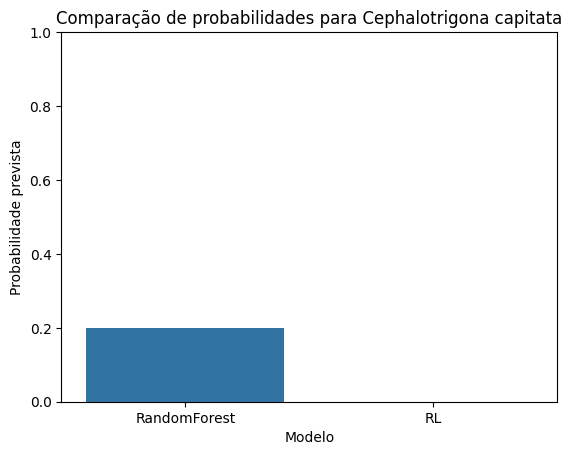

Calculando probabilidades para todos os modelos:   2%|▏         | 1/42 [00:00<00:05,  7.08it/s]

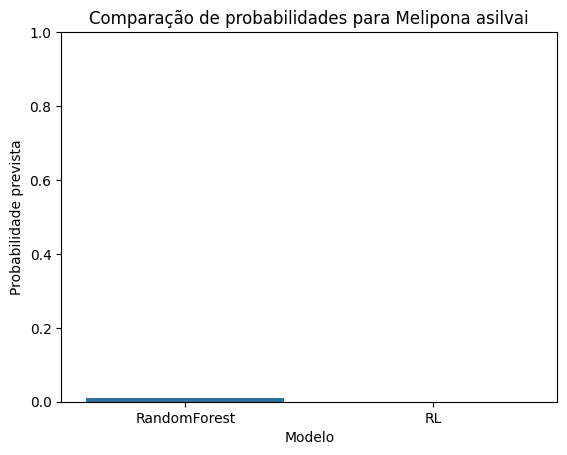

Calculando probabilidades para todos os modelos:   5%|▍         | 2/42 [00:00<00:05,  7.76it/s]

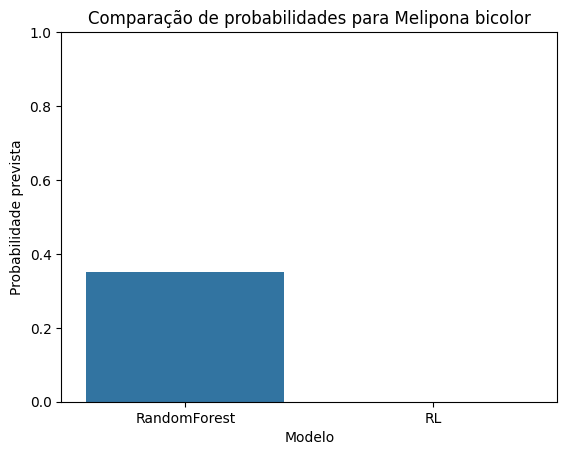

Calculando probabilidades para todos os modelos:   7%|▋         | 3/42 [00:00<00:04,  7.89it/s]

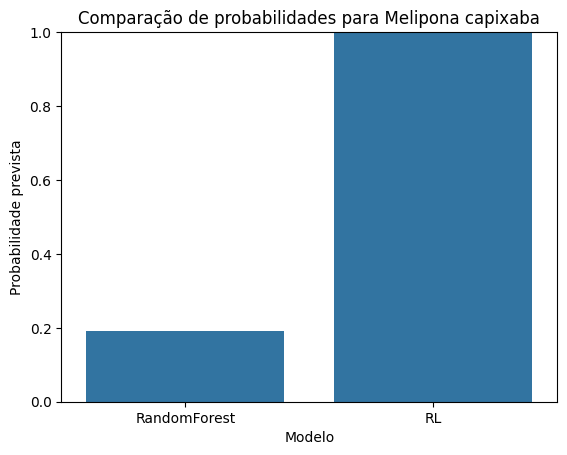

Calculando probabilidades para todos os modelos:  10%|▉         | 4/42 [00:00<00:04,  8.56it/s]

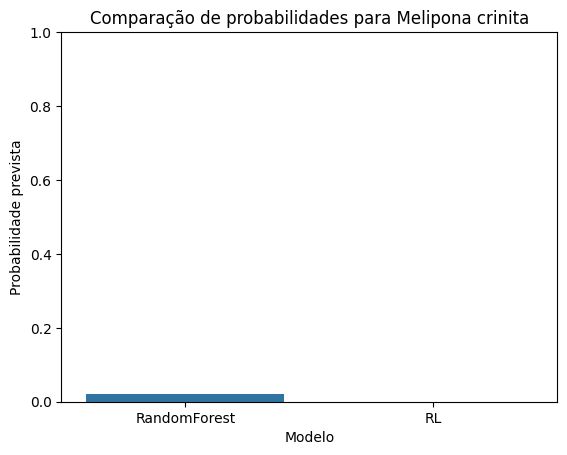

Calculando probabilidades para todos os modelos:  12%|█▏        | 5/42 [00:00<00:04,  8.69it/s]

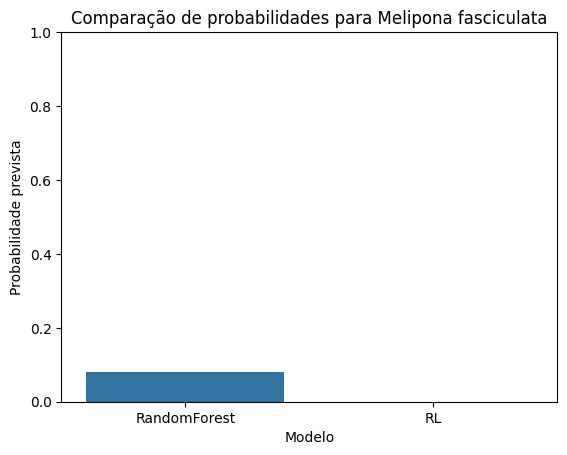

Calculando probabilidades para todos os modelos:  14%|█▍        | 6/42 [00:00<00:04,  8.95it/s]

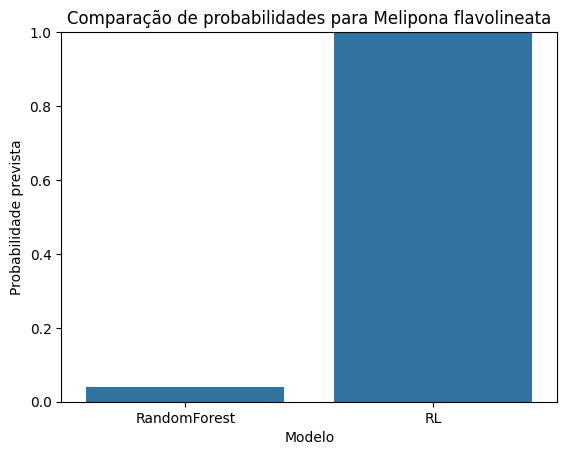

Calculando probabilidades para todos os modelos:  17%|█▋        | 7/42 [00:00<00:04,  7.83it/s]

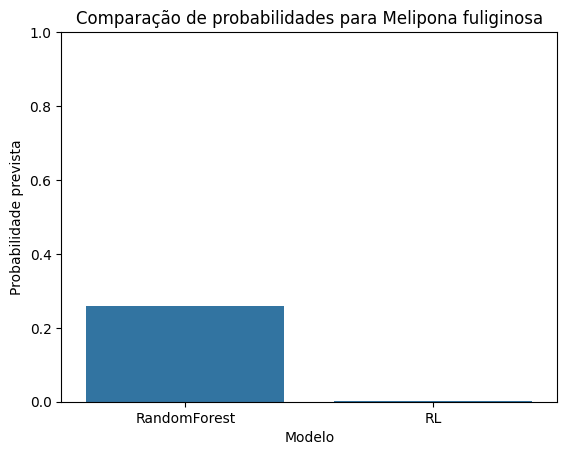

Calculando probabilidades para todos os modelos:  19%|█▉        | 8/42 [00:00<00:04,  8.39it/s]

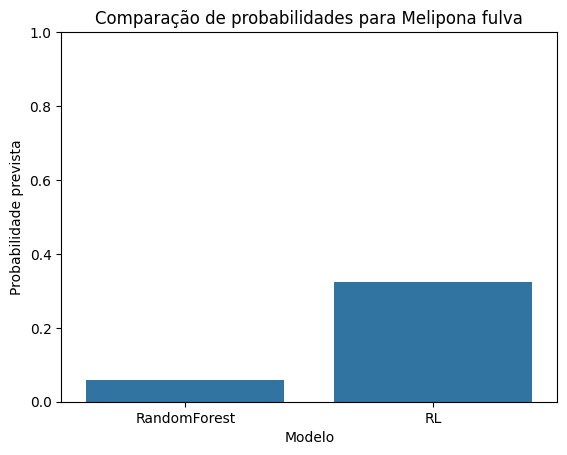

Calculando probabilidades para todos os modelos:  21%|██▏       | 9/42 [00:01<00:03,  8.62it/s]

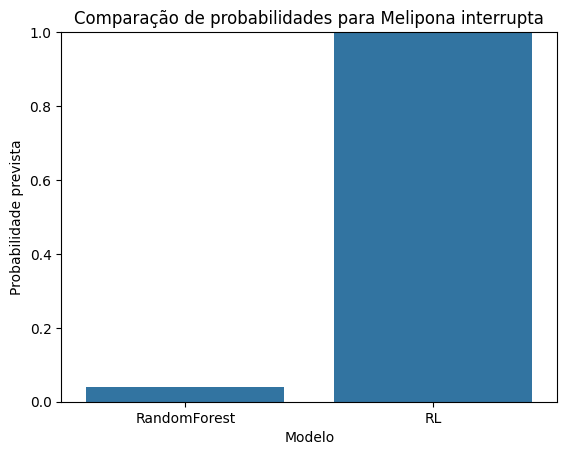

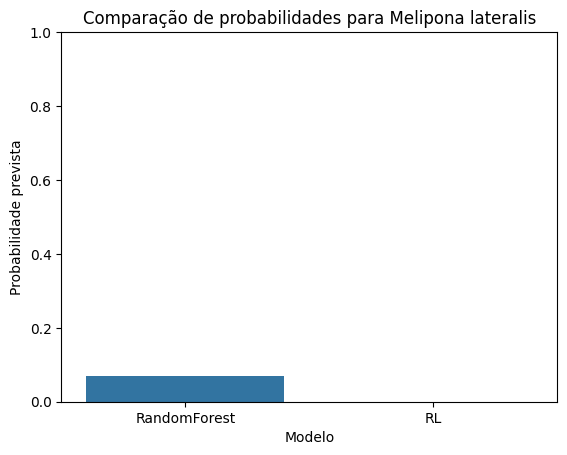

Calculando probabilidades para todos os modelos:  26%|██▌       | 11/42 [00:01<00:03,  9.10it/s]

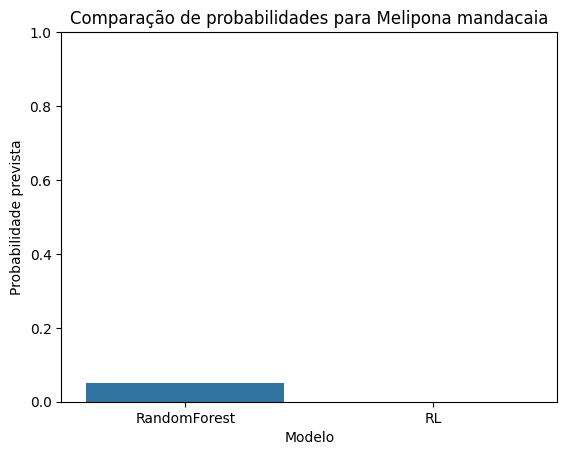

Calculando probabilidades para todos os modelos:  29%|██▊       | 12/42 [00:01<00:03,  8.23it/s]

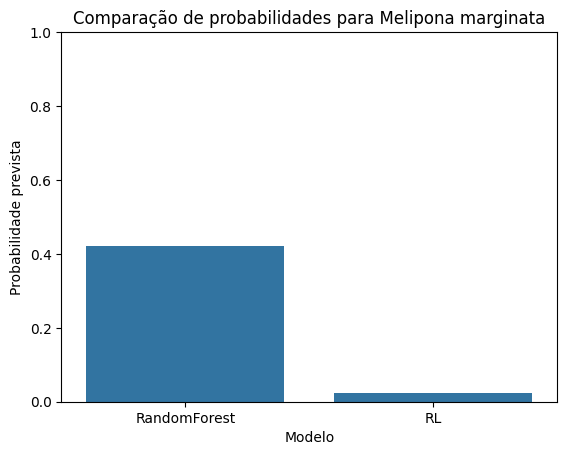

Calculando probabilidades para todos os modelos:  31%|███       | 13/42 [00:01<00:03,  8.13it/s]

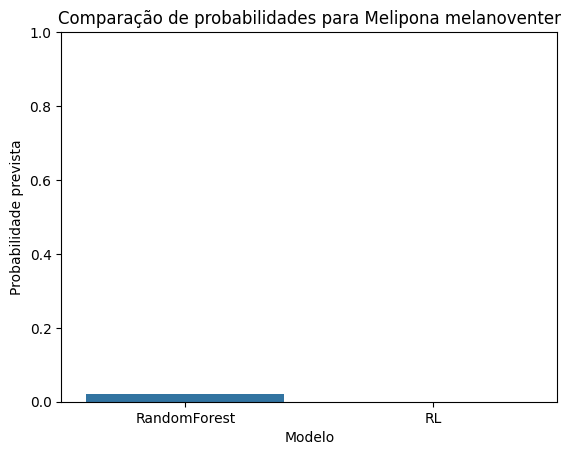

Calculando probabilidades para todos os modelos:  33%|███▎      | 14/42 [00:01<00:03,  7.68it/s]

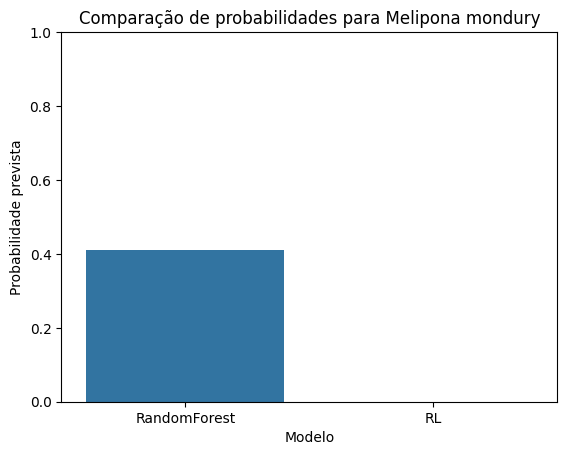

Calculando probabilidades para todos os modelos:  36%|███▌      | 15/42 [00:01<00:03,  8.00it/s]

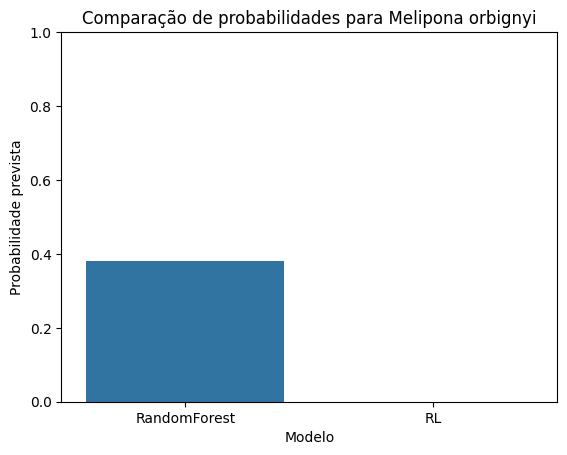

Calculando probabilidades para todos os modelos:  38%|███▊      | 16/42 [00:01<00:03,  8.14it/s]

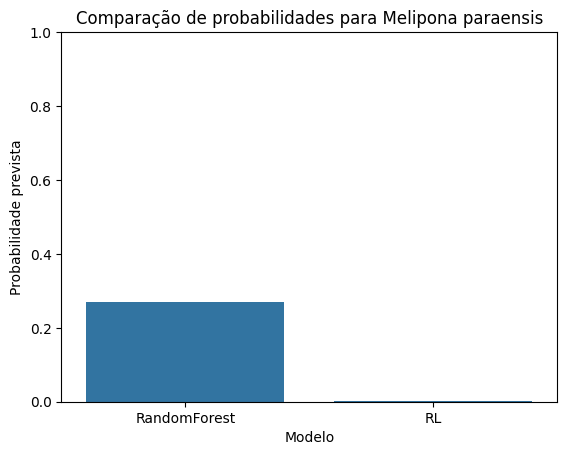

Calculando probabilidades para todos os modelos:  40%|████      | 17/42 [00:02<00:03,  7.67it/s]

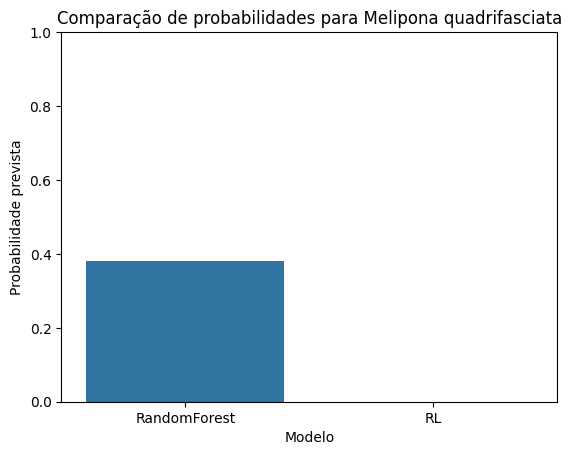

Calculando probabilidades para todos os modelos:  43%|████▎     | 18/42 [00:02<00:03,  7.47it/s]

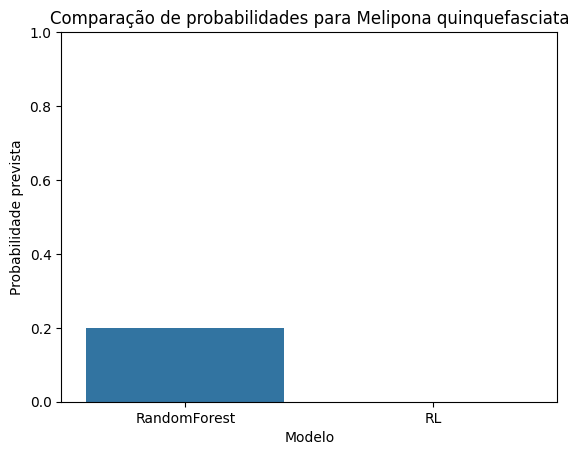

Calculando probabilidades para todos os modelos:  45%|████▌     | 19/42 [00:02<00:03,  7.32it/s]

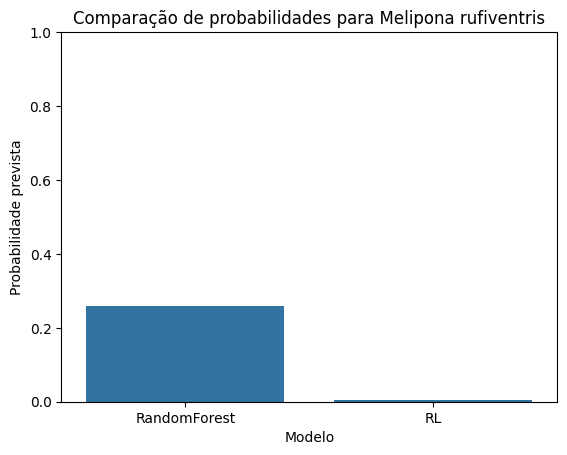

Calculando probabilidades para todos os modelos:  48%|████▊     | 20/42 [00:02<00:02,  7.46it/s]

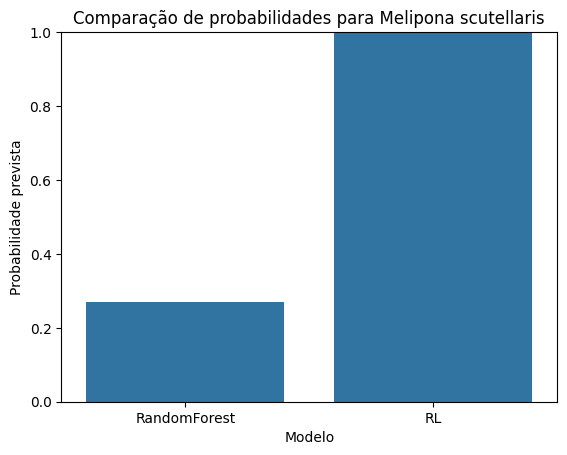

Calculando probabilidades para todos os modelos:  50%|█████     | 21/42 [00:02<00:04,  5.16it/s]

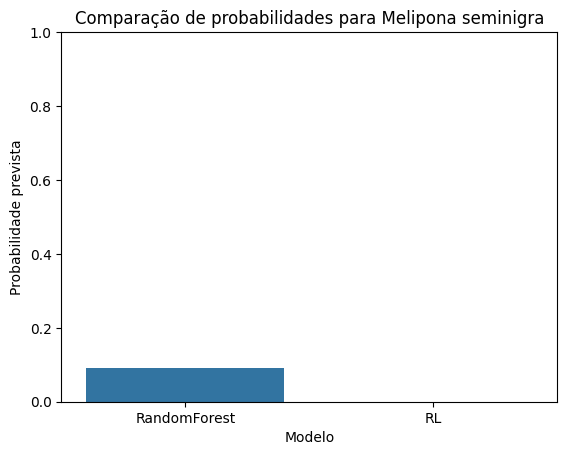

Calculando probabilidades para todos os modelos:  52%|█████▏    | 22/42 [00:03<00:03,  5.39it/s]

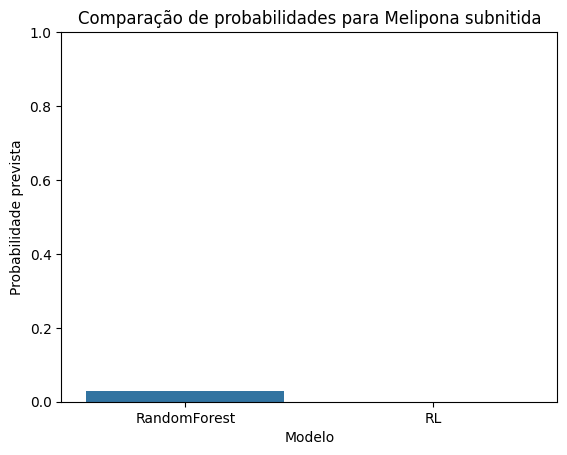

Calculando probabilidades para todos os modelos:  55%|█████▍    | 23/42 [00:03<00:03,  5.72it/s]

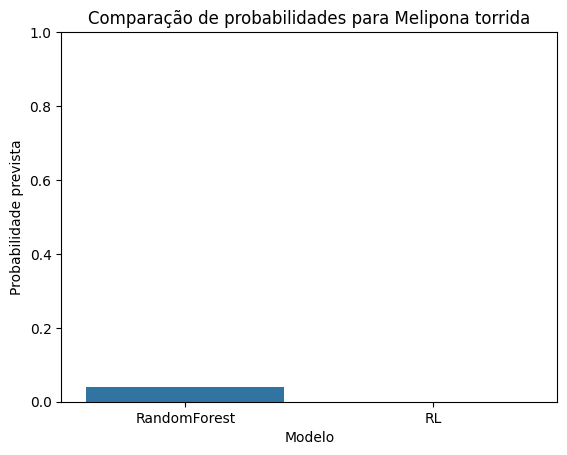

Calculando probabilidades para todos os modelos:  57%|█████▋    | 24/42 [00:03<00:02,  6.16it/s]

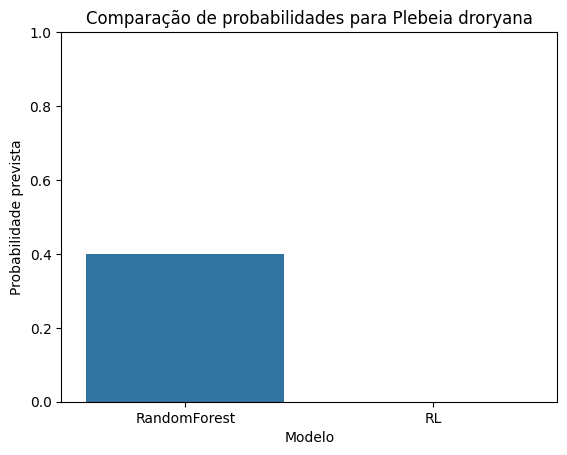

Calculando probabilidades para todos os modelos:  60%|█████▉    | 25/42 [00:03<00:02,  6.00it/s]

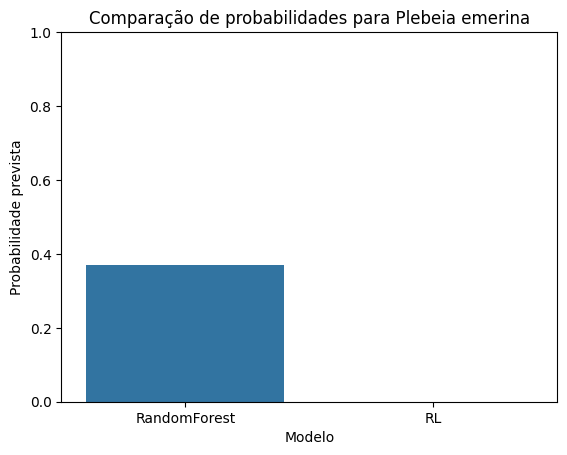

Calculando probabilidades para todos os modelos:  62%|██████▏   | 26/42 [00:03<00:02,  5.95it/s]

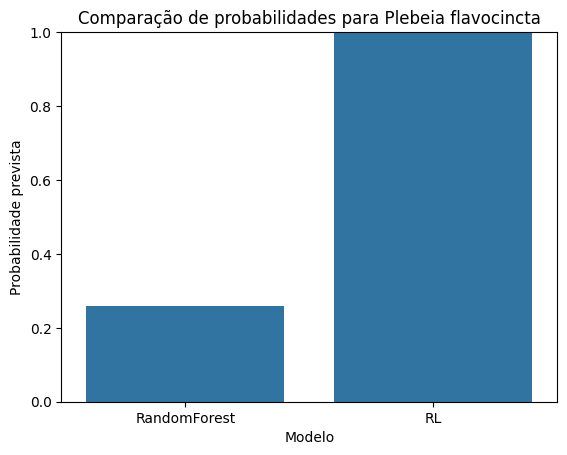

Calculando probabilidades para todos os modelos:  64%|██████▍   | 27/42 [00:03<00:02,  6.17it/s]

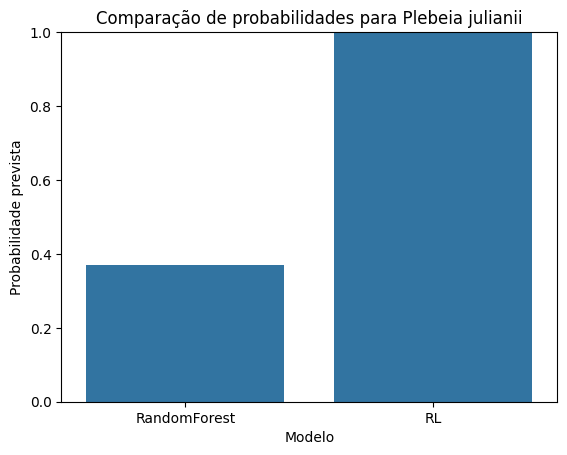

Calculando probabilidades para todos os modelos:  67%|██████▋   | 28/42 [00:03<00:02,  6.08it/s]

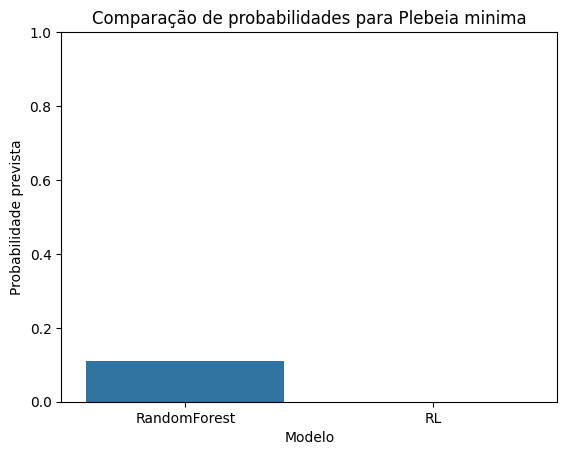

Calculando probabilidades para todos os modelos:  69%|██████▉   | 29/42 [00:04<00:02,  5.87it/s]

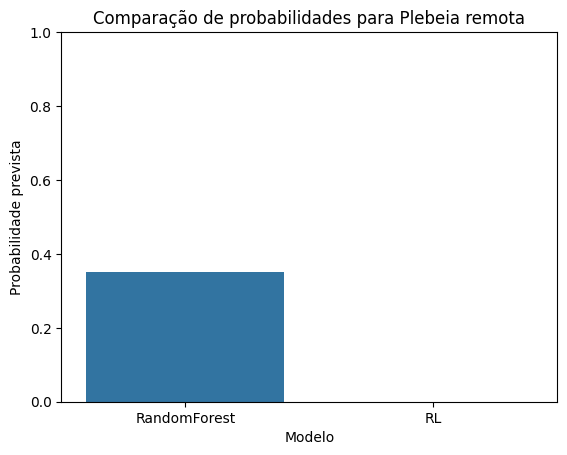

Calculando probabilidades para todos os modelos:  71%|███████▏  | 30/42 [00:04<00:02,  5.60it/s]

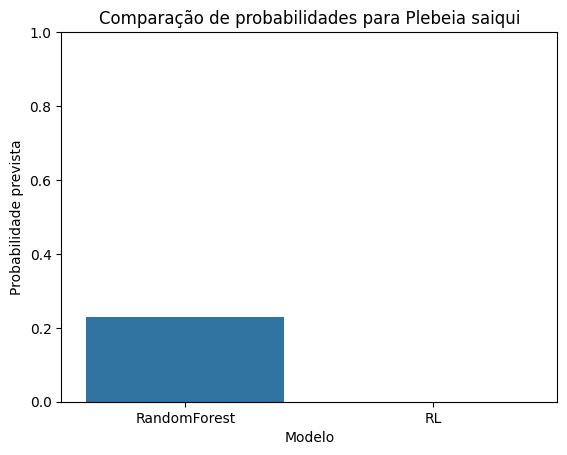

Calculando probabilidades para todos os modelos:  74%|███████▍  | 31/42 [00:04<00:01,  5.84it/s]

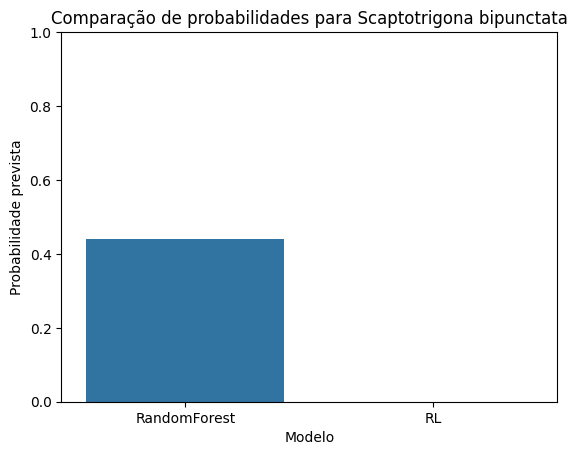

Calculando probabilidades para todos os modelos:  76%|███████▌  | 32/42 [00:04<00:01,  5.88it/s]

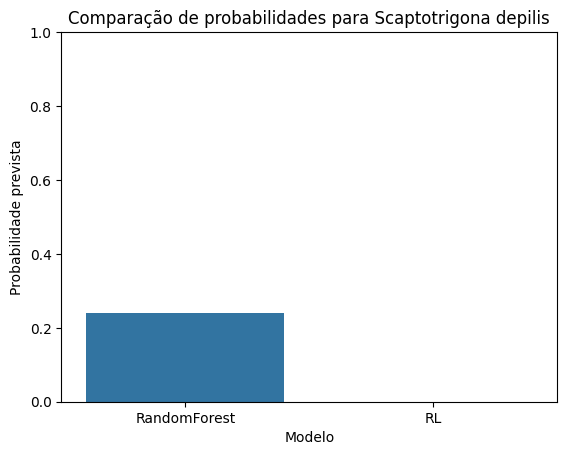

Calculando probabilidades para todos os modelos:  79%|███████▊  | 33/42 [00:04<00:01,  6.34it/s]

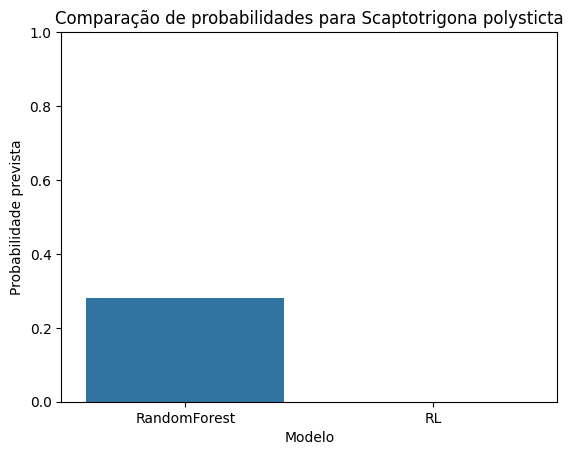

Calculando probabilidades para todos os modelos:  81%|████████  | 34/42 [00:04<00:01,  6.90it/s]

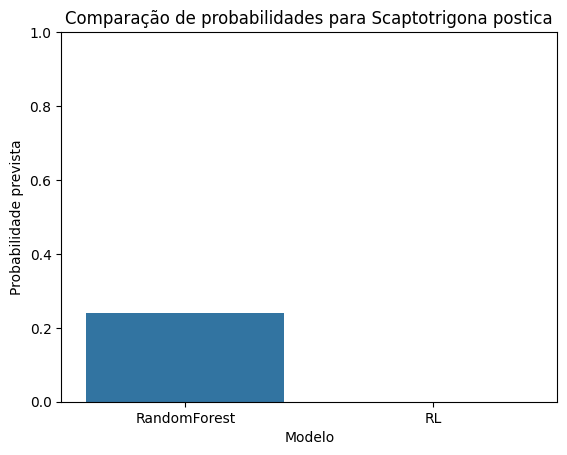

Calculando probabilidades para todos os modelos:  83%|████████▎ | 35/42 [00:05<00:01,  6.99it/s]

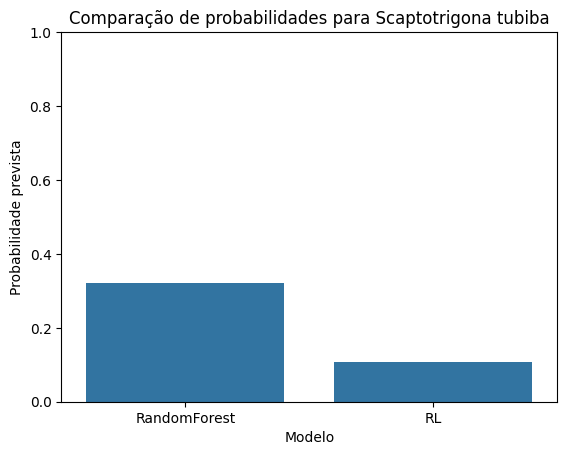

Calculando probabilidades para todos os modelos:  86%|████████▌ | 36/42 [00:05<00:00,  7.34it/s]

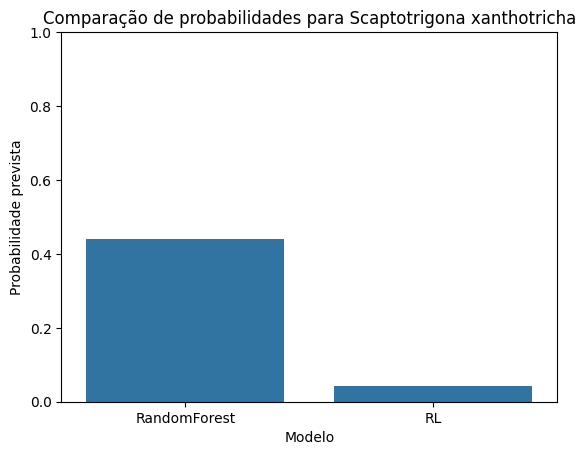

Calculando probabilidades para todos os modelos:  88%|████████▊ | 37/42 [00:05<00:00,  7.65it/s]

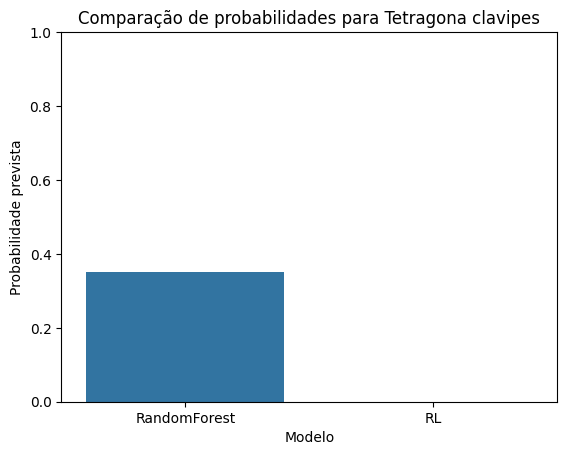

Calculando probabilidades para todos os modelos:  90%|█████████ | 38/42 [00:05<00:00,  8.03it/s]

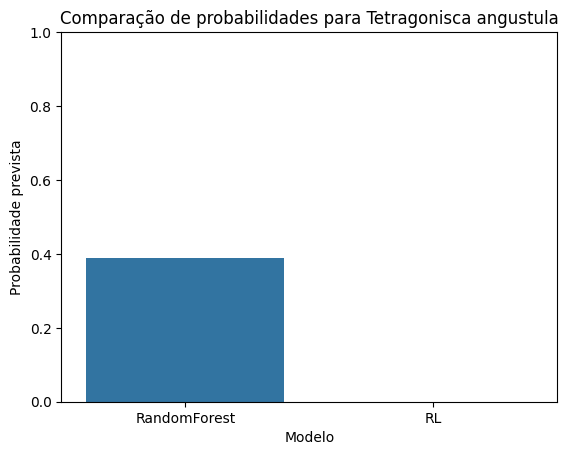

Calculando probabilidades para todos os modelos:  93%|█████████▎| 39/42 [00:05<00:00,  8.21it/s]

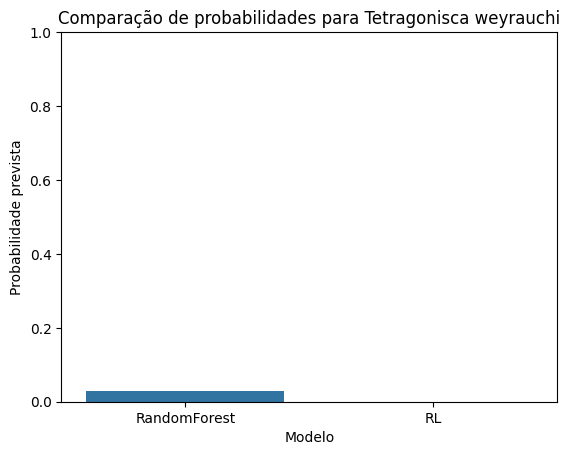

Calculando probabilidades para todos os modelos:  95%|█████████▌| 40/42 [00:05<00:00,  8.29it/s]

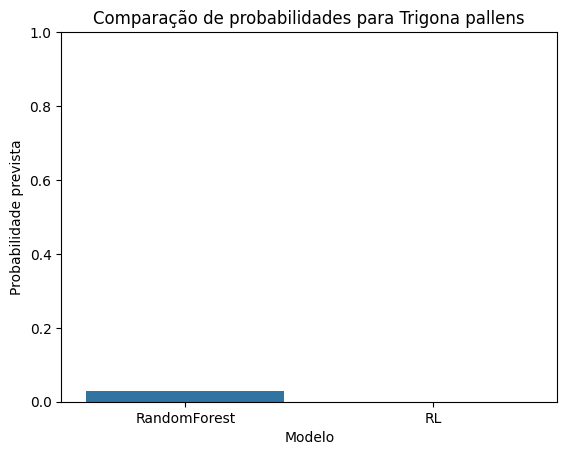

Calculando probabilidades para todos os modelos:  98%|█████████▊| 41/42 [00:05<00:00,  8.48it/s]

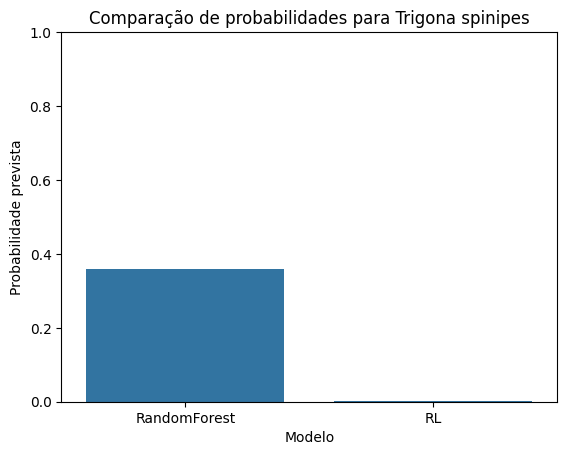

Calculando probabilidades para todos os modelos: 100%|██████████| 42/42 [00:05<00:00,  7.19it/s]


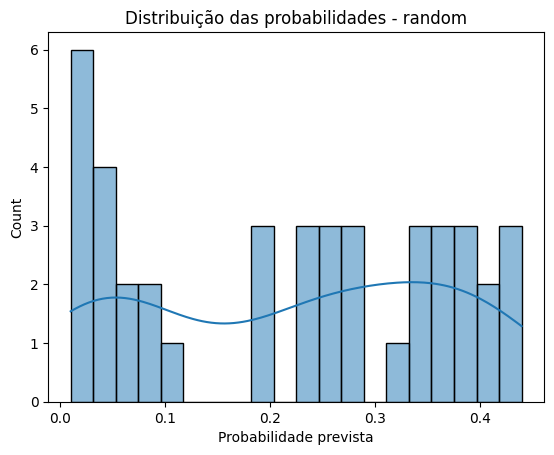


 Top 8 espécies mais prováveis - random
Scaptotrigona bipunctata: 44.00%
Scaptotrigona xanthotricha: 44.00%
Melipona marginata: 42.00%
Melipona mondury: 41.00%
Plebeia droryana: 40.00%
Tetragonisca angustula: 39.00%
Melipona orbignyi: 38.00%
Melipona quadrifasciata: 38.00%


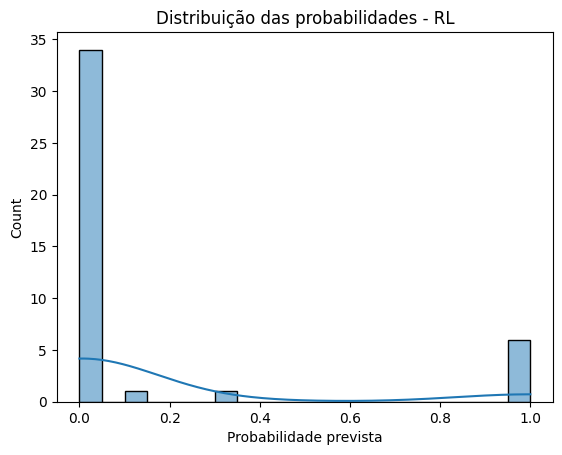


 Top 8 espécies mais prováveis - RL
Plebeia flavocincta: 100.00%
Plebeia julianii: 100.00%
Melipona interrupta: 100.00%
Melipona capixaba: 100.00%
Melipona scutellaris: 99.91%
Melipona flavolineata: 99.87%
Melipona fulva: 32.46%
Scaptotrigona tubiba: 10.71%


In [177]:
input_local = {
    'Latitude': -23.5,
    'Longitude': -46.6,
    'Sentinel-NDVI': 0.75,
    'Sentinel-NDWI': 0.3,
    'Precipitação': 150,
    'TempMedia': 25
}
X_input = pd.DataFrame([input_local])

for especie in tqdm(especies, desc="Calculando probabilidades para todos os modelos"):
    # Random Forest
    modelo_rf = modelos_por_especie_random.get(especie)
    if modelo_rf:
        prob_rf = modelo_rf.predict_proba(X_input[features])[:, 1][0]
        probs_random[especie] = prob_rf
        

    # RL
    modelo_rl = modelos_por_especie_rl.get(especie)
    if modelo_rl:
        probs_rl = modelo_rl.predict_proba(X_input[features])[:, 1][0]
        probs_regress[especie] = probs_rl

    
    plot_prob_comparacao(probs_random, probs_regress, especie)
    
plot_prob_distribution(probs_random, "random")
    

plot_prob_distribution(probs_regress, "RL")


In [172]:
probs_regress

{'Cephalotrigona capitata': np.float64(8.913614374011583e-11),
 'Melipona asilvai': np.float64(2.8972017590249275e-11),
 'Melipona bicolor': np.float64(1.9588133275004195e-05),
 'Melipona capixaba': np.float64(0.9999993928371935),
 'Melipona crinita': np.float64(1.1362197795172e-10),
 'Melipona fasciculata': np.float64(2.2234520137029802e-05),
 'Melipona flavolineata': np.float64(0.9986967011098679),
 'Melipona fuliginosa': np.float64(0.001919026077883942),
 'Melipona fulva': np.float64(0.3246182055780044),
 'Melipona interrupta': np.float64(0.9999997722338446),
 'Melipona lateralis': np.float64(8.039552535865405e-07),
 'Melipona mandacaia': np.float64(0.0003976976235726126),
 'Melipona marginata': np.float64(0.02316675744309487),
 'Melipona melanoventer': np.float64(5.3768799980974e-05),
 'Melipona mondury': np.float64(1.1777483547783885e-08),
 'Melipona orbignyi': np.float64(5.940296735705039e-14),
 'Melipona paraensis': np.float64(0.001715167976398018),
 'Melipona quadrifasciata': n

In [178]:
probs_ensemble = {}
for especie in especies:
    p1 = probs_random.get(especie, 0)
    p2 = probs_regress.get(especie, 0)
    probs_ensemble[especie] = (p1 + p2) / 2

top_especies_ensemble = sorted(probs_ensemble.items(), key=lambda x: x[1], reverse=True)

print("Top 8 espécies mais prováveis:")
for especie, prob in top_especies_ensemble[:8]:
    print(f"{especie}: {prob:.2%}")
    

especies_sorted = sorted(probs_ensemble.keys())
probs_vector = np.array([probs_ensemble[esp] for esp in especies_sorted])

idx_max = np.argmax(probs_vector)
especie_mais_provavel = especies_sorted[idx_max]
print(f"Espécie mais provável: {especie_mais_provavel} com probabilidade {probs_vector[idx_max]:.2%}")

Top 8 espécies mais prováveis:
Plebeia julianii: 68.50%
Melipona scutellaris: 63.45%
Plebeia flavocincta: 63.00%
Melipona capixaba: 59.50%
Melipona interrupta: 52.00%
Melipona flavolineata: 51.93%
Scaptotrigona xanthotricha: 24.06%
Melipona marginata: 22.16%
Espécie mais provável: Plebeia julianii com probabilidade 68.50%
